In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from gato import JuegoGato,minimax

In [2]:
juego=JuegoGato([0,0,0,0,0,0,0,0,0],1)
secuencia=[]
secuencias=[]
minimax(juego,1,secuencia,secuencias)

[0, 0]

In [3]:
len(secuencias)

255168

In [4]:
print(secuencias[0])

([0, 1, 2, 3, 4, 5, 6], 1)


In [5]:
episodios=[]
for i in range(len(secuencias)):
    juego=JuegoGato([0]*9,turno=1)
    episodio=[]
    for j in range(len(secuencias[i][0])):
        jugada=secuencias[i][0][j]
        tablero=juego.tablero.copy()
        turno=juego.jugador
        juego.jugar(jugada)
        tablero_siguiente=juego.tablero.copy()
        turno_siguiente=juego.jugador
        juego.evaluar()
        if juego.ganador:
            step=[tablero,turno,jugada,tablero_siguiente,turno_siguiente,juego.ganador,1]
        else:
            step=[tablero,turno,jugada,tablero_siguiente,turno_siguiente,0,0]
        episodio.append(step)
    episodios.append(episodio)

In [6]:
S={}
for episodio in episodios:
    for step in episodio:
        s=(tuple(step[0]),step[1])
        if s in S:
            S[s]+=1
        else:
            S[s]=1
        s=(tuple(step[3]),step[4])
        if s in S:
            S[s]+=1
        else:
            S[s]=1

In [7]:
len(S.keys())

5478

In [8]:
S

{((0, 0, 0, 0, 0, 0, 0, 0, 0), 1): 255168,
 ((1, 0, 0, 0, 0, 0, 0, 0, 0), -1): 55464,
 ((1, -1, 0, 0, 0, 0, 0, 0, 0), 1): 7336,
 ((1, -1, 1, 0, 0, 0, 0, 0, 0), -1): 2368,
 ((1, -1, 1, -1, 0, 0, 0, 0, 0), 1): 816,
 ((1, -1, 1, -1, 1, 0, 0, 0, 0), -1): 432,
 ((1, -1, 1, -1, 1, -1, 0, 0, 0), 1): 288,
 ((1, -1, 1, -1, 1, -1, 1, 0, 0), -1): 108,
 ((1, -1, 1, -1, 1, -1, 0, 1, 0), -1): 576,
 ((1, -1, 1, -1, 1, -1, -1, 1, 0), 1): 1152,
 ((1, -1, 1, -1, 1, -1, -1, 1, 1), -1): 1728,
 ((1, -1, 1, -1, 1, -1, 0, 1, -1), 1): 1152,
 ((1, -1, 1, -1, 1, -1, 1, 1, -1), -1): 1728,
 ((1, -1, 1, -1, 1, -1, 0, 0, 1), -1): 108,
 ((1, -1, 1, -1, 1, 0, -1, 0, 0), 1): 360,
 ((1, -1, 1, -1, 1, 1, -1, 0, 0), -1): 576,
 ((1, -1, 1, -1, 1, 1, -1, -1, 0), 1): 1152,
 ((1, -1, 1, -1, 1, 1, -1, -1, 1), -1): 576,
 ((1, -1, 1, -1, 1, 1, -1, 0, -1), 1): 1152,
 ((1, -1, 1, -1, 1, 1, -1, 1, -1), -1): 2880,
 ((1, -1, 1, -1, 1, 0, -1, 1, 0), -1): 576,
 ((1, -1, 1, -1, 1, 0, -1, 1, -1), 1): 1152,
 ((1, -1, 1, -1, 1, 0, -1, 0, 

In [9]:
import tensorflow as tf
from keras.models import Sequential,clone_model
from keras.layers import Dense,Input
from keras.optimizers import Adam
from keras.losses import mean_squared_error

2024-04-18 11:15:36.071323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
seed=12122008
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [83]:
batch_size=64
gamma=0.95
optimizer=Adam(learning_rate=1e-3)
model=Sequential()
model.add(Input(shape=(10,)))
model.add(Dense(128))
model.add(Dense(9,activation="linear"))
target=clone_model(model)
target.set_weights(model.get_weights())
x=[]
y=[]
for epoch in range(4):
    indices=np.random.randint(len(episodios),size=batch_size)
    batch=[episodios[i] for i in indices]
    for sample in batch:
        states=[]
        actions=[]
        rewards=[]
        next_states=[]
        dones=[]
        for step in sample:
            s_t=step[0].copy()
            s_t.append(step[1])
            states.append(s_t)
            actions.append(tf.one_hot(step[2],9).numpy())
            s_t_1=step[3].copy()
            s_t_1.append(step[4])
            next_states.append(s_t_1)
            rewards.append(step[5])
            dones.append(step[6])
        states=np.asarray(states)
        actions=np.asarray(actions)
        rewards=np.asarray(rewards).reshape(-1,1)
        next_states=np.asarray(next_states)
        dones=np.asarray(dones).reshape(-1,1)

        next_Q=target.predict(next_states,verbose=0)
        max_next_Q=np.max(next_Q,axis=1)
        target_Q=(rewards+dones*gamma*max_next_Q)
        with tf.GradientTape() as tape:
            raw_Q=model(states)
            Q=tf.reduce_sum(raw_Q*actions,axis=1,keepdims=True)
            loss=tf.reduce_mean(mean_squared_error(target_Q,Q))
        grads=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
    x.append(epoch)
    y.append(loss.numpy())
    print(epoch,loss)    
    if epoch%10==0:
        target.set_weights(model.get_weights())

0 tf.Tensor(0.21759519, shape=(), dtype=float32)
1 tf.Tensor(0.12146595, shape=(), dtype=float32)
2 tf.Tensor(0.04986623, shape=(), dtype=float32)
3 tf.Tensor(0.025619023, shape=(), dtype=float32)


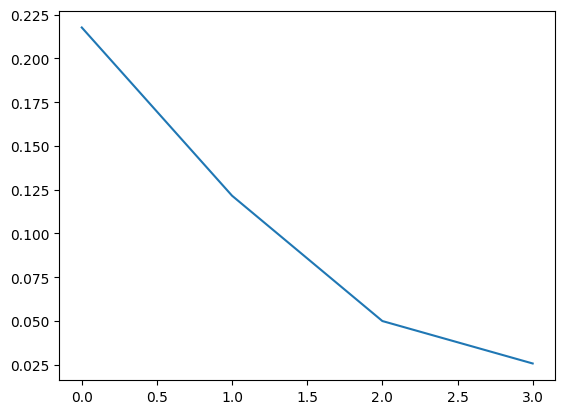

In [84]:
plt.plot(x,y)

In [85]:
test=np.asarray([[1,1,0,-1,-1,0,0,0,0,1]])
model.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([[ 0.14399718,  0.26059917,  0.35751563, -0.128458  , -0.09704196,
        -0.10242597,  0.08167473,  0.07753574, -0.0264122 ]],
      dtype=float32)

In [86]:
test=np.asarray([[0,0,0,0,0,0,0,0,0,1]])
np.argmax(model.predict(test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2